### Pytania: 
1. W jaki sposób przetworzyć w tym przypadku dane kategorialne? Istnieje MCA, czyli PCA dla kategorialnych 
2. Jakie porównania robić między sobą
3. Czy badać pod kątem zbalansowania?
4. Czy użyć WEKI np. do porównania, czy warto

In [23]:
%matplotlib inline

In [241]:
import pandas as pd
from pathlib import Path 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import prince
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


DATA_DIR = Path("../../data")

In [167]:
dataset = pd.read_csv(DATA_DIR / 't-shirts.csv')

In [168]:
dataset.head()

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium


Cechy zostały podzielone na nominalne, czyli bez uporządkowania między nimi, oraz na porządkowe, gdyż możemy ustalić porządek między wartościami. 

In [185]:
nominal = ['material', 'color']
ordinal = ['size', 'sleeves']

features = nominal + ordinal

goal = 'demand'

labels = dataset[goal].drop_duplicates().values.tolist()
labels

['medium', 'high', 'low']

In [170]:
size_labels = ['XS', 'S', 'M' ,'L', 'XL', 'XXL', '3XL']
sleeves_labels = ['short', 'long']

## Eksploracja danych 

Dane są pełne i w całości kategorialne. Większość kategori, oprócz sleeves, jest niezbalansowanych. Będzie to prawdopodobnie miało wpływ na niektóre algorytmy. Jako że są to dane kategorialne, to jedyną ciekawą statystyką jest częstość występowania wartości w danych kategoriach, oraz korelacja (współwystępowanie) z innymi wartościami. Oprócz zmiennej którą chcemy przewidywać nie ma korelacji między atrybutami, co może być istotne w kontekście założeń niektóych algorytmów. 

Kategoria 'demand' jest zmienną, którą chcemy przewidzieć. 

In [5]:
profile = ProfileReport(dataset, title = "T Shirts Report")

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
profile.to_file("tshirts_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Rozkład cech ze względu na przypisaną kategorię

<Axes: xlabel='sleeves', ylabel='count'>

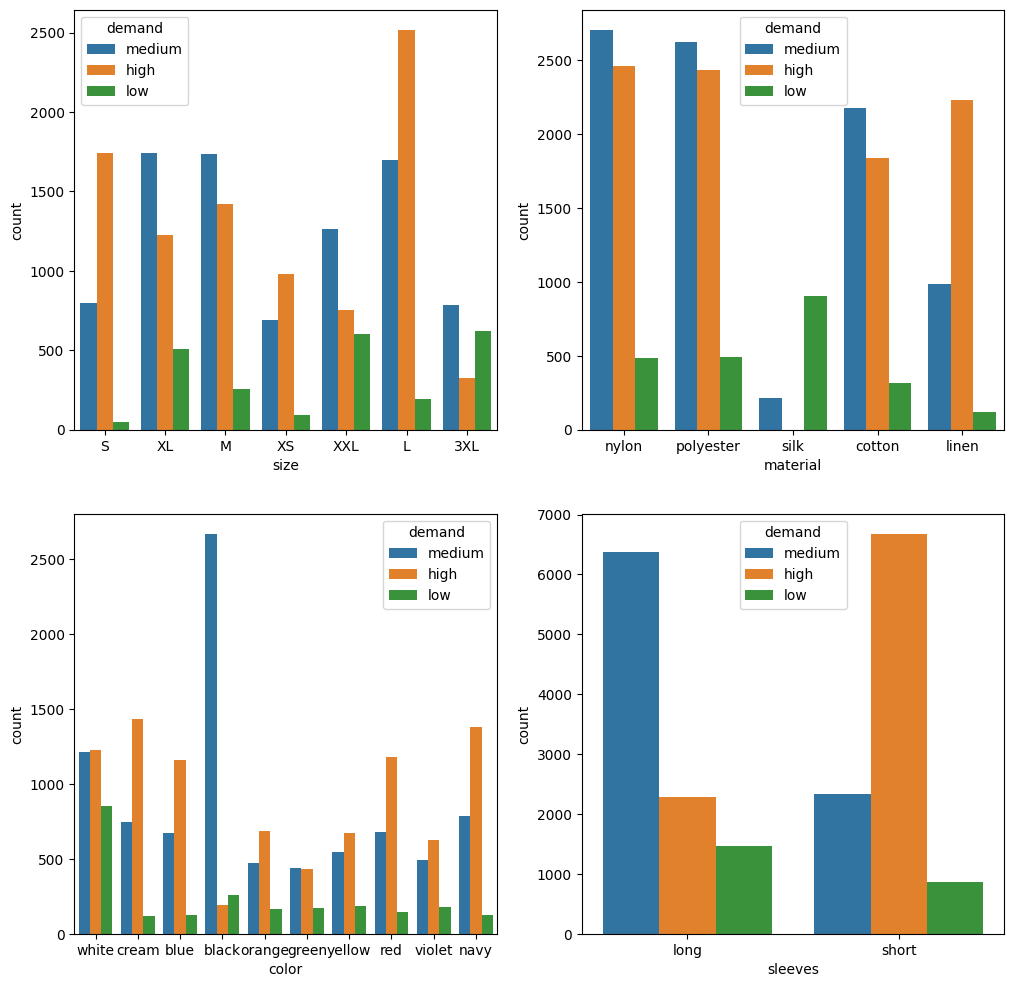

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.countplot(dataset, x='size', hue=dataset[goal], ax=axes[0, 0])
sns.countplot(dataset, x='material', hue=dataset[goal], ax=axes[0, 1])
sns.countplot(dataset, x='color', hue=dataset[goal], ax=axes[1, 0])
sns.countplot(dataset, x='sleeves', hue=dataset[goal], ax=axes[1, 1])

### Podział danych na zbiory

In [12]:
dataset

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium
...,...,...,...,...,...
19995,M,polyester,white,short,medium
19996,M,linen,white,long,high
19997,XXL,cotton,cream,short,high
19998,L,nylon,cream,long,medium


In [171]:
from sklearn.model_selection import train_test_split

# Could add stratification
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, stratify=dataset[goal], random_state=42)

In [172]:
print(f'{train_dataset.size}, {test_dataset.size}')

75000, 25000


Wykorzystany został podział z warstwami ze względu na liczność klas docelowych 

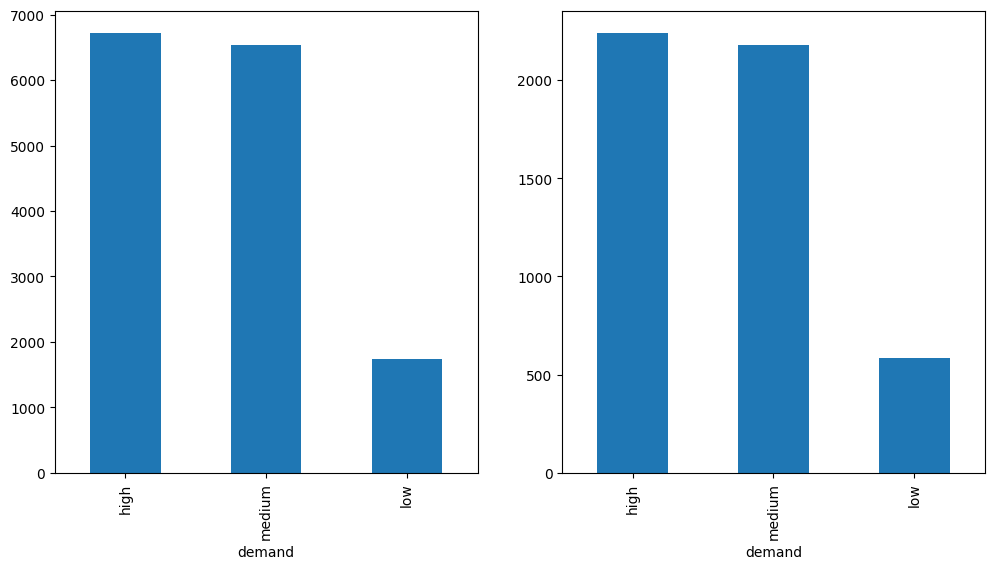

In [118]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_dataset[goal].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
test_dataset[goal].value_counts().plot(kind='bar')
plt.show()

In [173]:
features_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [174]:
preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', features_pipeline, features)
])

### Naiwny Bayes

In [121]:
from sklearn.naive_bayes import CategoricalNB

complete_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB())
])

In [122]:
complete_pipeline.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [123]:
score = complete_pipeline.score(test_dataset[features], test_dataset[goal])

In [124]:
score

0.831

In [175]:
cat_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'alpha': [1.0, 0.5],
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring='balanced_accuracy', cv=5, verbose=1, refit=True)

cat_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', cat_nb_grid_search)
])

cat_nb_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'alpha': [1.0, 0.5],
                                          'class_prior': [None,
                                                          [0.5, 0.1, 0.4]],
                                          'fit_prior': [True, False]},
                              scoring='balanced_accuracy', verbose=1))])

O dziwo klasyfikator działa lepiej, gdy nie są używane prawdopodobieństwa a priori 

In [176]:
pd.DataFrame.from_dict(cat_nb_gs_pipeline.named_steps['estimator'].cv_results_)[['params', 'mean_test_score']]

,params,mean_test_score
0,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.710542
1,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.829481
2,"{'alpha': 1.0, 'class_prior': [0.5, 0.1, 0.4],...",0.705273
3,"{'alpha': 1.0, 'class_prior': [0.5, 0.1, 0.4],...",0.705273
4,"{'alpha': 0.5, 'class_prior': None, 'fit_prior...",0.710542
5,"{'alpha': 0.5, 'class_prior': None, 'fit_prior...",0.829481
6,"{'alpha': 0.5, 'class_prior': [0.5, 0.1, 0.4],...",0.705273
7,"{'alpha': 0.5, 'class_prior': [0.5, 0.1, 0.4],...",0.705273


In [178]:
cat_nb = cat_nb_gs_pipeline.named_steps['estimator'].best_estimator_
cat_nb

CategoricalNB(fit_prior=False)

In [251]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support

def visualize_classification_metrics(y_true, y_pred, name=None):
    metrics = ['precision', 'recall', 'fscore', 'support']
    values = np.array(precision_recall_fscore_support(y_true, y_pred, labels=labels))
    
    values[-1, :] = values[-1, :] / np.sum(values[-1, :])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pcolormesh(values,
                    cmap='GnBu')
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)) + 0.5, labels=labels)
    ax.set_yticks(np.arange(len(metrics)) + 0.5, labels=metrics)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(metrics)):
        for j in range(len(labels)):
            ax.text(j + 0.5, i + 0.5, np.round(values[i, j], 2),
                           ha="center", va="center", color="w")
    
    ax.set_title(f"Classification metrics {' - ' + name if name else ''}")
    fig.tight_layout()
    plt.show()

In [249]:
def visualize_confusion_matrix(y_true, y_pred, name=None):
    values = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(values, display_labels=labels)
    disp.plot()
    
    plt.title(f"Confusion Matrix {' - ' + name if name else ''}")
    fig.tight_layout()
    plt.show()

In [256]:
def class_accuracy(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return matrix.diagonal() / matrix.sum(axis=1)

In [252]:
confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels=labels)

array([[1772,  112,  293],
       [ 309, 1848,   84],
       [  64,    0,  518]], dtype=int64)

<Figure size 500x500 with 0 Axes>

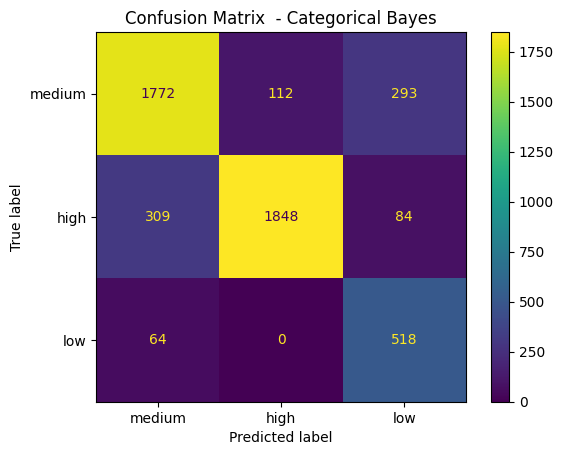

In [253]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), 'Categorical Bayes')

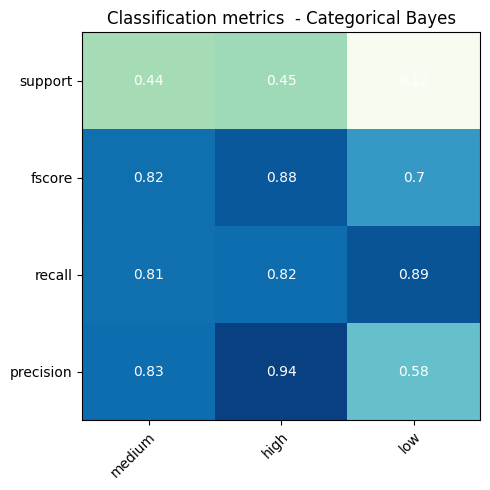

In [254]:
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), 'Categorical Bayes')

In [274]:
def visualize_compare_algorithms(X, y, algorithms, names):
    
    results = [precision_recall_fscore_support(y, alg.predict(X), average='micro') for alg in algorithms]
    values = np.array([res[:3] for res in results])
    accuracy = [accuracy_score(y, alg.predict(X)) for alg in algorithms]
    
    metrics = ['precision', 'recall', 'fscore', 'accuracy']
    
    values = np.c_[values, np.array(accuracy)]
    
    fig, ax = plt.subplots()
    ax.pcolormesh(values, cmap='GnBu')
    
    # Show all ticks and label them with the respective list entries
    ax.set_yticks(np.arange(len(names)) + 0.5, labels=names)
    ax.set_xticks(np.arange(len(metrics)) + 0.5, labels=metrics)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(names)):
        for j in range(len(metrics)):
            ax.text(j + 0.5, i + 0.5, np.round(values[i, j], 2),
                           ha="center", va="center", color="w")
    
    ax.set_title(f"Algoritms Comparison")
    fig.tight_layout()
    plt.show()

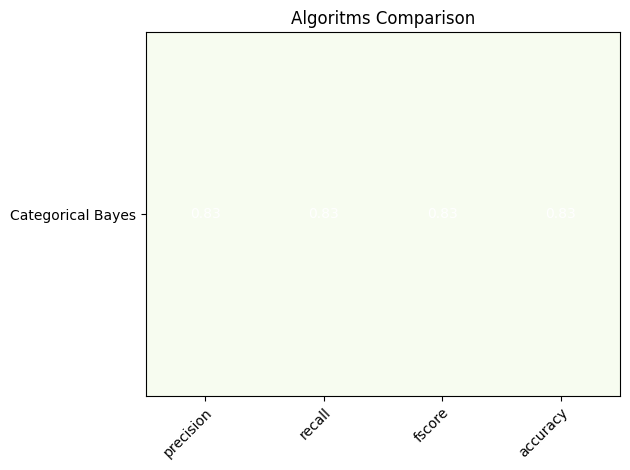

In [277]:
visualize_compare_algorithms(test_dataset[features], test_dataset[goal], [cat_nb_gs_pipeline], ['Categorical Bayes'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier

cat_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'alpha': [1.0, 0.5],
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring='balanced_accuracy', cv=5, verbose=1, refit=True)

cat_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', cat_nb_grid_search)
])

cat_nb_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

In [26]:
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(train_dataset)

In [39]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.339,7.71%,7.71%
1,0.301,6.84%,14.54%
2,0.207,4.71%,19.25%


In [43]:
mca.row_coordinates(train_dataset).head()

,0,1,2
16996,-0.516987,-0.056071,1.273505
6568,0.338001,-0.012486,0.422579
1833,-0.553098,0.117035,-0.510869
5971,-0.614908,0.052940,0.268107
5586,0.738862,-0.914231,0.224460


In [44]:
mca.column_coordinates(train_dataset)

,0,1,2
size_3XL,0.706857,0.898960,0.137780
size_L,-0.295358,-0.070147,-0.448644
size_M,0.217745,-0.150799,-0.389108
size_S,-0.745701,-0.046588,0.957203
size_XL,0.406064,0.066816,0.187596
size_XS,-0.302475,-0.215213,-0.225762
size_XXL,0.141104,-0.185990,0.108433
material_cotton,-0.020650,-0.191656,0.679951
material_linen,-0.438752,0.222968,0.681594
material_nylon,-0.062313,-0.143553,-0.331398


In [45]:
import altair as alt
alt.data_transformers.enable("vegafusion")

mca.plot(
    train_dataset,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [46]:
mca.column_contributions_.head().style.format('{:.0%}')

,0,1,2
size_3XL,3%,5%,0%
size_L,1%,0%,4%
size_M,0%,0%,2%
size_S,4%,0%,12%
size_XL,2%,0%,1%


In [47]:
mca.row_cosine_similarities(train_dataset).head()

,0,1,2
16996,0.066755,0.000785,0.405066
6568,0.022350,0.000030,0.034935
1833,0.066042,0.002957,0.056342
5971,0.093052,0.000690,0.017690
5586,0.167664,0.256700,0.015474


In [48]:
mca.column_cosine_similarities(train_dataset).head()

,0,1,2
size_3XL,0.047771,0.077265,0.001815
size_L,0.024395,0.001376,0.056287
size_M,0.009706,0.004655,0.030996
size_S,0.083434,0.000326,0.137474
size_XL,0.035122,0.000951,0.007496


In [49]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

enc.fit(train_dataset)

OrdinalEncoder()

In [50]:
enc.categories_

[array(['3XL', 'L', 'M', 'S', 'XL', 'XS', 'XXL'], dtype=object),
 array(['cotton', 'linen', 'nylon', 'polyester', 'silk'], dtype=object),
 array(['black', 'blue', 'cream', 'green', 'navy', 'orange', 'red',
        'violet', 'white', 'yellow'], dtype=object),
 array(['long', 'short'], dtype=object),
 array(['high', 'low', 'medium'], dtype=object)]

In [57]:
train_encoded = enc.transform(train_dataset)
test_encoded = enc.transform(test_dataset)

In [58]:
X_train, y_train = train_encoded[:, :len(predictor_columns)], train_encoded[:, len(predictor_columns)]
X_test, y_test = test_encoded[:, :len(predictor_columns)], test_encoded[:, len(predictor_columns)]

In [59]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()

In [60]:
clf.fit(X_train, y_train)

CategoricalNB()

In [63]:
y_pred = clf.predict(X_test)

In [67]:
y_pred.astype(int)

array([0, 0, 2, ..., 2, 0, 0])

In [68]:
reversed = enc.categories_[-1][y_pred.astype(int)]

In [69]:
reversed

array(['high', 'high', 'medium', ..., 'medium', 'high', 'high'],
      dtype=object)

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
confusion_matrix(y_pred, y_test)

array([[1907,   67,  218],
       [   0,  261,   53],
       [ 283,  282, 1929]], dtype=int64)